
#<b>1) connect to colab and import</b>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import imutils
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import ndimage
from scipy.optimize import minimize
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler as ms
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

try:
  os.mkdir('drive/MyDrive/eschergrid')
except: 
  pass
finally:  
  try: 
    os.chdir('drive/MyDrive/eschergrid')
  except: 
    print('wrong directory error')

In [ ]:
# unzip for the first time
# or else don't unzip

!wget -nc "docs.google.com/uc?export=download&id=1p2_UbIHQcTVPz4j2qwEuEkpSOHIuVuwZ"
!wget -nc "docs.google.com/uc?export=download&id=1pvdgAs1orm7oW6M0h2uVo77FcTBUYLN_"

!unzip -n 'uc?export=download&id=1pvdgAs1orm7oW6M0h2uVo77FcTBUYLN_'
!unzip -n 'uc?export=download&id=1p2_UbIHQcTVPz4j2qwEuEkpSOHIuVuwZ'

--2021-01-15 00:56:34--  http://docs.google.com/uc?export=download&id=1p2_UbIHQcTVPz4j2qwEuEkpSOHIuVuwZ
Resolving docs.google.com (docs.google.com)... 172.217.214.113, 172.217.214.100, 172.217.214.138, ...
Connecting to docs.google.com (docs.google.com)|172.217.214.113|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://docs.google.com/uc?export=download&id=1p2_UbIHQcTVPz4j2qwEuEkpSOHIuVuwZ [following]
--2021-01-15 00:56:34--  https://docs.google.com/uc?export=download&id=1p2_UbIHQcTVPz4j2qwEuEkpSOHIuVuwZ
Connecting to docs.google.com (docs.google.com)|172.217.214.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2sb86qv6i85oqkgihpcfj7lepkdt26ri/1610672175000/12971709187850627045/*/1p2_UbIHQcTVPz4j2qwEuEkpSOHIuVuwZ?e=download [following]
--2021-01-15 00:56:34--  https://doc-00-a4-docs.googleusercontent.com

In [ ]:
# This is PYVIPS, a "faster"
# alternative to what we will actually do

# %capture
# !apt-get update
# !apt-get upgrade
# !apt-get install libvips
# !pip install pyvips
# !pip install cffi
# !pip show pyvips

# import pyvips

#<b>2) load data, visualize and define functions</b>

In [ ]:
def plot_images(images, labels=False):
  L = len(images)
  if L>6:
    print('too many images (max 6)')
    return
  f, ax = plt.subplots(1,L, figsize=(L*5,L))
  for i in range(L):
    if len(images[i].shape)>2:
      ax[i].imshow(images[i])
    else:
      ax[i].imshow(images[i], cmap='gray')
    ax[i].set_axis_off()
    if labels:
      ax[i].set_title(labels[i])
  plt.show()

def rotate(img, deg: float):
  """
  rotates "deg" degrees
  clockwise
  """
  return imutils.rotate(img, -1*deg)


def scale(img, f: float):
  """
  scales by a factor "f"
  """
  # Store the original shape
  s = img.shape
  width = int(img.shape[1] * f)
  height = int(img.shape[0] * f)
  dim = (width, height)

  if f>1:
    # Define the pixel indexes in order to 
    # return an image with equal amount of pixels
    ind = [
           slice(
               int((s[0]*f)//2-s[0]//2),
               int((s[0]*f)//2+s[0]//2),
           ),
           slice(
               int((s[1]*f)//2-s[1]//2),
               int((s[1]*f)//2+s[1]//2),
           ),
    ]
    if len(s)>2:
      return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)[ind[0],ind[1],:]
    else:
      return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)[ind[0],ind[1]]

  canvas = np.zeros(s)
  new = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  a,b,c,d = s[0]//2-height//2, s[0]//2+height//2, s[1]//2-width//2, s[1]//2+width//2
  if len(s)>2:
    canvas[a:b,c:d,:] = new[:b-a, :d-c,:]
  else:
    canvas[a:b,c:d] = new[:b-a, :d-c] 
  return canvas

def detect_ridges(gray, sigma=1.0):
    H_elems = hessian_matrix(gray, sigma=sigma, order='rc')
    maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
    return maxima_ridges, minima_ridges

history = {2:[],3:[],4:[],5:[]}
base, target = [],[]
def optimize_image(deg, f):
  # Compute the cosine distance
  out = distance.cosine(target[0].reshape(-1,) -
                        rotate(scale(base[0],f),deg).reshape(-1,)
                        )
  history[n].append((deg, f, out))
  return out


def simone_method():
  """
  IMAGE must be 2,3,4 or 5
  """
  # Initialize the angle and the scaling factor
  # 1 degree (almost 0, the identity) and a scaling factor of "1" (identity)
  degree, scaling = 1,1

  # Define the optimizer
  minimizer = lambda x,y: minimize(x,y,
                                  method=["BFGS","Nelder-Mead"][1],
                                  options={'maxiter':50}
                                  )
  # Four  iterations
  for _ in range(6):

    # even iterations are for the scaling factor
    if _%2==0:

      res = minimizer(
                lambda x: optimize_image(degree,x),
                scaling,
                )
      
      # update the scaling factor
      scaling = res.x[0]

    # odd iterations are for the degrees
    else:

      res = minimizer(
            lambda Y: optimize_image(Y, scaling),
                degree, 
                )
      
      # update the rotation angle
      degree = res.x[0]

    # print the last params
    print(f'parameters after lap {_+1} are: ',res.x)

  return degree, scaling 

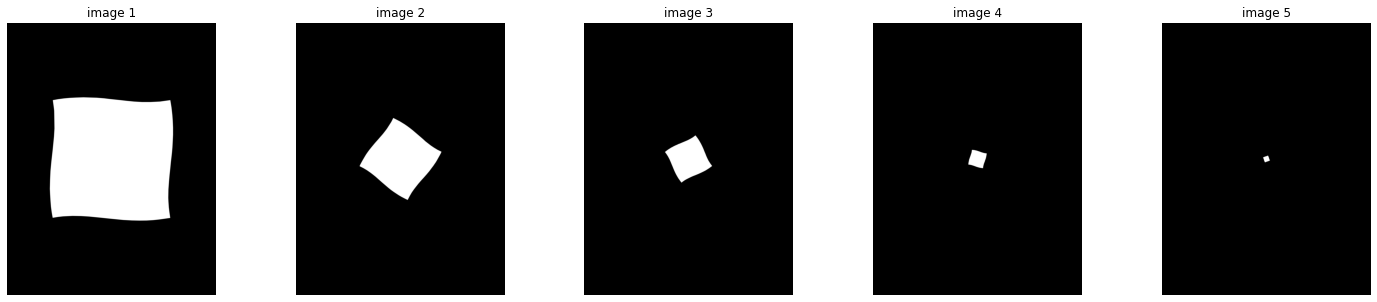

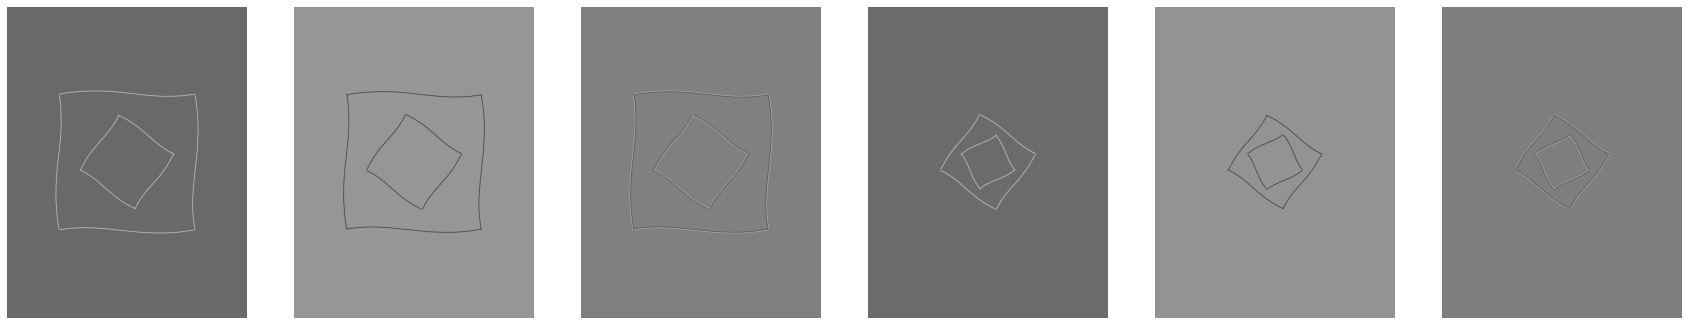

In [ ]:
# Names of the files
types = ['B', 'TRANSP'][0] #RGB or Transparent
files = [
 f'escher_grid CUADRADO 1 {types}.png',
 f'escher_grid CUADRADO 2 {types}.png',
 f'escher_grid CUADRADO 3 {types}.png',
 f'escher_grid CUADRADO 4 {types}.png',
 f'escher_grid CUADRADO 5 {types}.png',
 ]

# Build a dictionary
images = {i+1:x for i,x in enumerate(files)}

images = {k:cv2.imread(v, 
                       #cv2.IMREAD_UNCHANGED,
                       cv2.IMREAD_COLOR,
                       ) for k,v in images.items()}

# Show them
plot_images([images[i+1] for i in range(len(images))],
            labels=[f'image {i+1}' for i in range(len(images))])
img = cv2.imread(files[0], 0) # 0 imports a grayscale

# Make the base and target images please
BASE_IMAGE = detect_ridges((images[1]-images[2])[:,:,0], sigma=3.0)
TARGET_IMAGE = detect_ridges((images[2]-images[3])[:,:,0], sigma=3.0)
BASE_IMAGES = list(BASE_IMAGE) + [BASE_IMAGE[0]+BASE_IMAGE[1]]
TARGET_IMAGES = list(TARGET_IMAGE) + [TARGET_IMAGE[0]+TARGET_IMAGE[1]]
plot_images(BASE_IMAGES+TARGET_IMAGES)

# convert to float plz
BASE_IMAGES = [k.astype(float) for k in BASE_IMAGES]
TARGET_IMAGES = [k.astype(float) for k in TARGET_IMAGES]

<b>Hey! This part should perform the square-auto-generation in a manner that allows us to recycle the 'old optimization viewing code'. Let me do it at most during friday night. Sorry for the inconvenience, Gaston</b>

In [ ]:
results = {2:None, 3:None, 4:None, 5:None}

ALIGN_INDEX = 0
for n in [2,3,4,5]:
  results[n] = simone_method(n)

cost = {0:[],1:[],2:[]}
local_images = [img.copy() in BASE_IMAGES]
for idx,img in enumerate(BASE_IMAGES):
  local_cost, iter, LIMIT = 1,1,1000
  while iter<LIMIT:
    deg = np.random.randint(-90,90)
    cost[idx].append(distance.cosine(TARGET_IMAGES[idx], rotate(BASE_IMAGES[idx], deg)))

    iter+=1



#<b>3) Results</b> (contains old information but should also work with 'our new code')

parameters after lap 1 are:  [1.88164063]
parameters after lap 2 are:  [-31.02431641]
parameters after lap 3 are:  [1.9775602]
parameters after lap 4 are:  [-34.52629216]
parameters after lap 1 are:  [1.59970703]
parameters after lap 2 are:  [-26.54433594]
parameters after lap 3 are:  [1.68844078]
parameters after lap 4 are:  [-26.53024074]
parameters after lap 1 are:  [2.1640625]
parameters after lap 2 are:  [0.96855469]
parameters after lap 3 are:  [2.1640625]
parameters after lap 4 are:  [-41.16934393]
parameters after lap 1 are:  [2.73046875]
parameters after lap 2 are:  [37.46142578]
parameters after lap 3 are:  [2.84352722]
parameters after lap 4 are:  [36.68591436]


<b>PLOT THE PARAMETERS AND COST DURING THE OPTIMIZATION PROCESS</b>

In [ ]:
def show(n):

  f, ax = plt.subplots(figsize=(20,4))

  deg, sc, cost = zip(*history[n])
  xvec = range(len(deg))

  sdeg = ms().fit([[x] for x in deg])
  ax.plot(sdeg.transform([[x] for x in deg]), c='orange')
  ax.scatter(xvec, sdeg.transform([[x] for x in deg]), label='degrees', c='orange')
  #ax.hlines(sdeg.transform([[30]])[0],0,len(sc), color='orange', ls=":", label='optimal degrees')

  ax.plot(sc, c='b')
  ax.scatter(xvec, sc, label='scaling', c='b')
  #ax.hlines(1.9,0,len(deg),color='b', ls=":", label='optimal scaling')

  ax.plot(ms().fit_transform([[x] for x in cost]), c='k')
  ax.scatter(range(len(deg)),ms().fit_transform([[x] for x in cost]), label='cost', c='k' )

  ax.set_ylim(-0.3,3.2)
  ax.legend()
  plt.show()

  f,ax = plt.subplots(1,3, figsize=(14,10))
  ax[2].imshow(scale(rotate(images[n],results[n][0]),results[n][1]).astype('uint8'))
  ax[1].imshow(images[n-1].astype('uint8'))
  ax[0].imshow(images[n].astype('uint8'))
  ax[2].set_title(f'optimized\nDEG:{round(results[n][0],2)} , SCALE:{round(results[n][1],2)}')
  ax[1].set_title('TARGET') 
  ax[0].set_title('BASE')
  plt.show()

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core

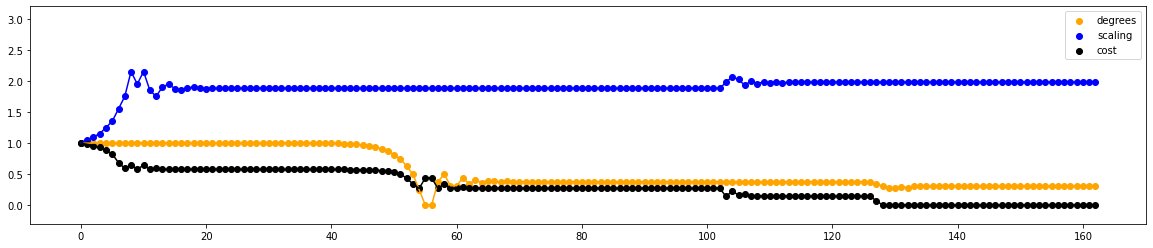

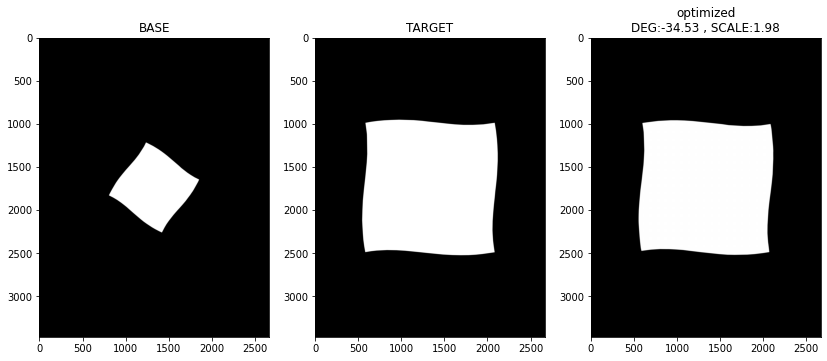

In [ ]:
show(2)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core

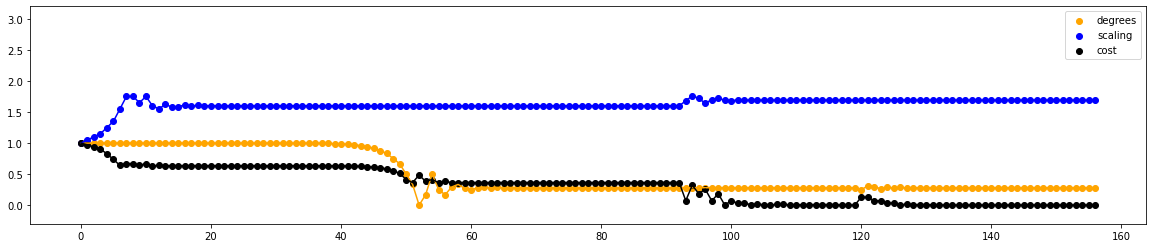

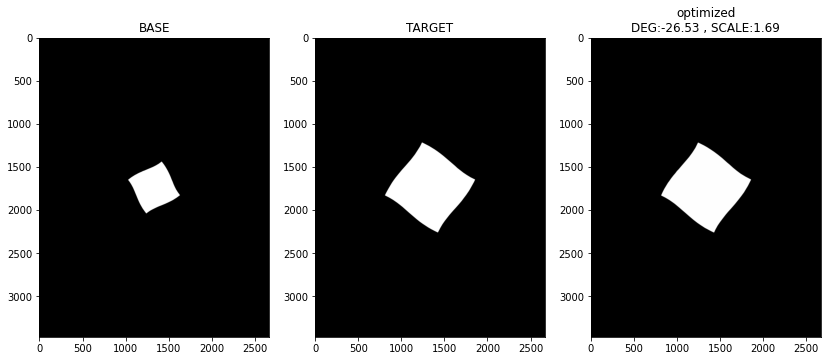

In [ ]:
show(3)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core

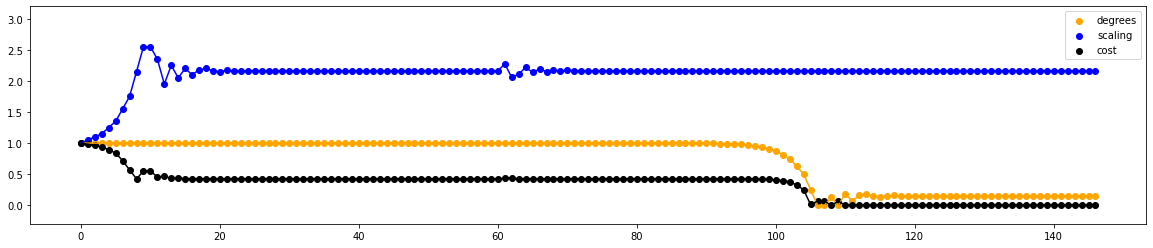

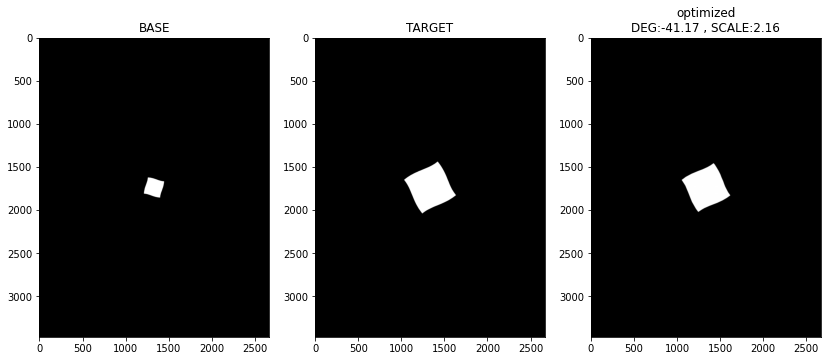

In [ ]:
show(4)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core

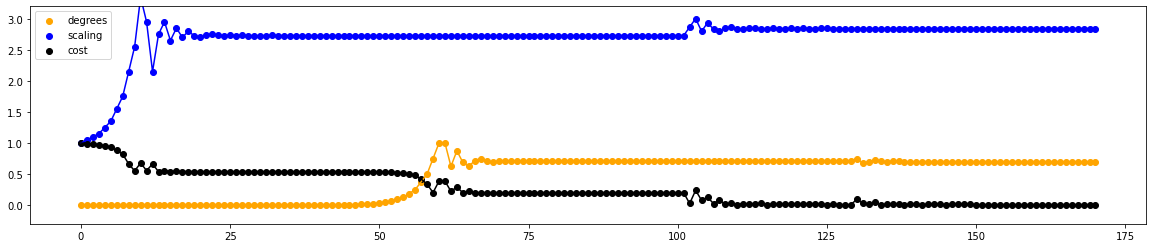

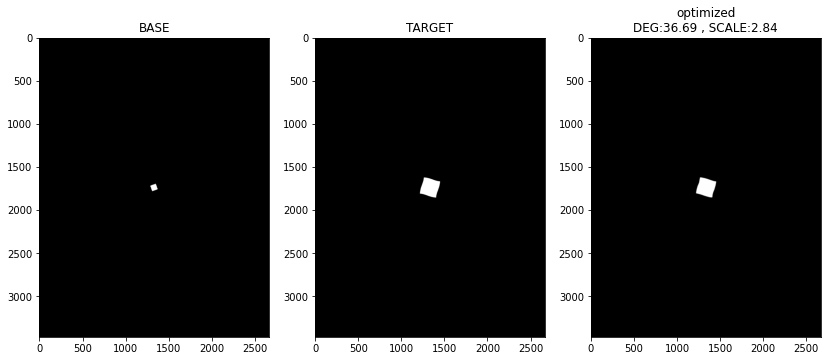

In [ ]:
show(5)

<b>THE PARAMETERS FOR EACH</b>

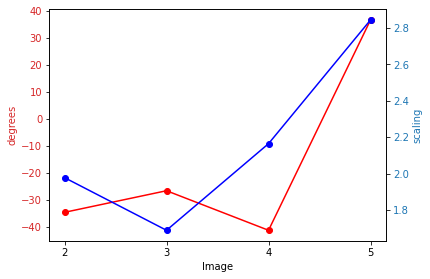

In [ ]:
degrees, scaling = [],[]
for i in [2,3,4,5]:
  local = results[i]
  degrees.append(local[0])
  scaling.append(local[1])

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Image')
ax1.set_ylabel('degrees', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks([2,3,4,5])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('scaling', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


ax1.scatter([2,3,4,5], degrees, label="degrees", c='r')
ax1.plot([2,3,4,5],degrees, c='r')
ax2.scatter([2,3,4,5], scaling, label="scaling", c='b')
ax2.plot([2,3,4,5],scaling, c='b')
#ax1.legend()
#ax2.legend()
plt.show()

#<b>Appendix A) enlarge the last two images in order to reduce the error in the optimization parameters</b> (used in the old version)

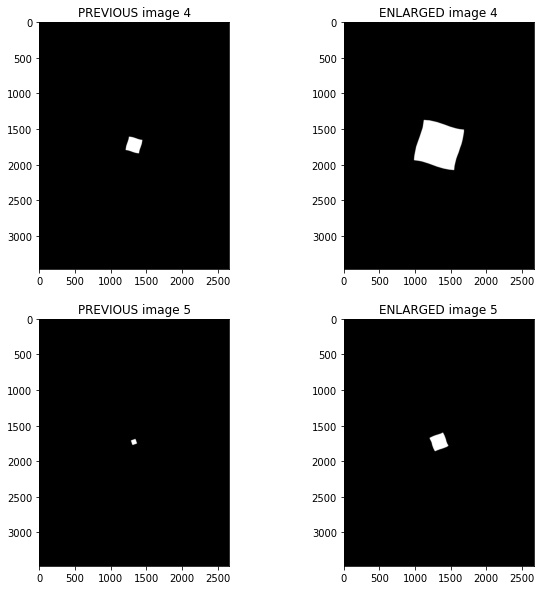

In [ ]:
factor = 3
f, ax = plt.subplots(2,2,figsize=(10,10))

ax[0,0].imshow(images[4].astype('uint8'))
ax[0,0].set_title('PREVIOUS image 4')
ax[1,0].imshow(images[5].astype('uint8'))
ax[1,0].set_title('PREVIOUS image 5')
for im in [4,5]:
  images[im] = scale(images[im],factor)
ax[0,1].imshow(images[4].astype('uint8'))
ax[0,1].set_title('ENLARGED image 4')
ax[1,1].imshow(images[5].astype('uint8'))
ax[1,1].set_title('ENLARGED image 5')

plt.show()

In [ ]:
history[5] = []
results[5] = simone_method(5)

parameters after lap 1 are:  [2.7359375]
parameters after lap 2 are:  [37.29453125]
parameters after lap 3 are:  [2.85563477]
parameters after lap 4 are:  [36.60800594]


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/ma/core

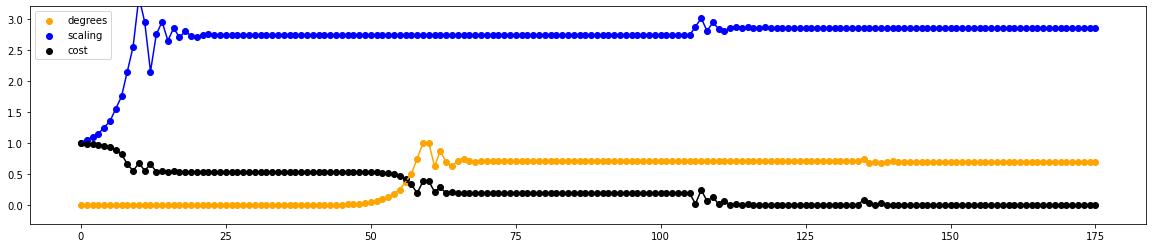

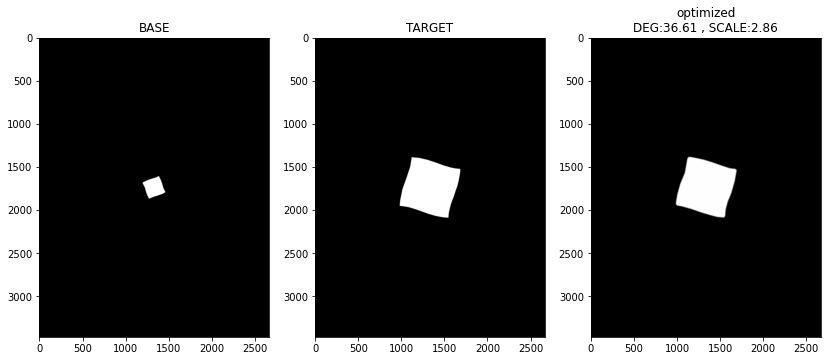

In [ ]:
show(5)

<b>At last show that the diference in rotation and scaling factor is not due to a lack-of-resolution error.</b>

<i>COMMENT: Rotation 'may' be degenerated by 90°, so the sign in ±35° could be irrelevant. What about the scaling ~30% difference tho? </i>

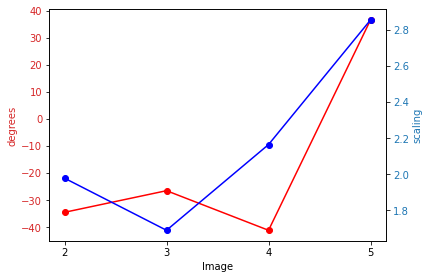

In [ ]:
degrees, scaling = [],[]
for i in [2,3,4,5]:
  local = results[i]
  degrees.append(local[0])
  scaling.append(local[1])

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Image')
ax1.set_ylabel('degrees', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks([2,3,4,5])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('scaling', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


ax1.scatter([2,3,4,5], degrees, label="degrees", c='r')
ax1.plot([2,3,4,5],degrees, c='r')
ax2.scatter([2,3,4,5], scaling, label="scaling", c='b')
ax2.plot([2,3,4,5],scaling, c='b')
#ax1.legend()
#ax2.legend()
plt.show()